by Antonia Kraft, matr.-nr.: 11731292

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import numpy as np
from transformers import pipeline
import csv
import math
import json
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import MonthLocator
import scipy.stats as stats
import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap


In [ ]:
#read in reddit data
redditdf = pd.read_csv("reddit_posts.csv")
redditdf

C:\Users\Antonia\AppData\Local\Temp\ipykernel_24792\1744389879.py:2: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  redditdf = pd.read_csv("reddit_posts.csv")


,body,timestamp,cleaned_text,neg,neu,pos,compound
0,Yes December 30 I sold it,2022-04-06 09:32:46,Yes December 30 I sold,0.0,0.649,0.351,0.4019
1,![img](emote|t5_2th52|4260) Just need help,2022-04-06 09:15:56,Just need help,0.0,0.501,0.499,0.4574
2,??? Alright bro.,2022-04-06 08:10:16,??? Alright bro.,0.0,0.441,0.559,0.3695
3,Elon is with more than some of the S&P 500 com...,2022-04-06 08:10:03,Elon SP 500 companies.,0.0,1.0,0.0,0.0000
4,Thank you Officer :),2022-04-06 08:09:49,Thank Officer :),0.0,0.267,0.733,0.6705
...,...,...,...,...,...,...,...
6484959,">And as in the dark all Cats are grey, the Ple...",2022-12-30 02:12:05,">And dark Cats grey, Pleasure corporal Enjoyme...",0.083,0.578,0.339,0.9062
6484960,Poor Red Wings but Buffalo as a city needs a win,2022-12-30 02:12:00,Poor Red Wings Buffalo city needs win,0.126,0.554,0.32,0.6310
6484961,What’s your definition of rich here?,2022-12-30 02:11:56,What’s definition rich here?,0.0,0.581,0.419,0.5574
6484962,Jpow wont give up until all of you go back to ...,2022-12-30 02:11:51,Jpow wont give go back school,0.0,1.0,0.0,0.0000


In [ ]:
#read in yahoo fin data
findf = pd.read_csv("Finance_Data.csv")

findf = findf.sort_values(by = "Date", ascending=True)
findf["Date"] = pd.to_datetime(findf["Date"]) 

findf

,Unnamed: 0,Value,Date,Symbol
0,0,1.577500,2020-01-02,GME
756,0,324.869995,2020-01-02,SPY
1512,0,55.961926,2020-01-02,MSCI_WORLD
1,1,1.470000,2020-01-03,GME
757,1,322.410004,2020-01-03,SPY
...,...,...,...,...
1510,754,383.440002,2022-12-29,SPY
2263,751,64.459999,2022-12-29,MSCI_WORLD
1511,755,382.429993,2022-12-30,SPY
755,755,18.459999,2022-12-30,GME


In [ ]:
#prep data for regression
redditdf["timestamp"] = pd.to_datetime(redditdf["timestamp"])
redditdf["timestamp"] = redditdf["timestamp"].dt.date
redditdf = redditdf.sort_values(by = "timestamp", ascending = False)

redditdf

,body,timestamp,cleaned_text,neg,neu,pos,compound
6484963,Cream pie a pussy,2022-12-30,Cream pie pussy,0.0,1.0,0.0,0.0000
201303,You know he ended up on his knees and liked it🍆,2022-12-30,You know ended knees liked it🍆,0.0,0.797,0.203,0.4215
201312,Well tbh by the way you’ve worded this it seem...,2022-12-30,Well tbh way you’ve worded seems wife know inv...,0.114,0.82,0.066,-0.6808
201311,"Oh my gourd! \r\n\r\n\r\n*I am a bot, and this...",2022-12-30,"Oh gourd! *I bot, action performed automatical...",0.0,0.909,0.091,0.3802
201310,A tale as old as time.,2022-12-30,A tale old time.,0.0,1.0,0.0,0.0000
...,...,...,...,...,...,...,...
3018653,buy the dip pussy,2020-12-08,buy dip pussy,0.0,1.0,0.0,0.0000
3018654,Holding shares is never stupid. Stonk only go up,2020-12-08,Holding shares never stupid. Stonk go,0.0,0.585,0.415,0.6093
3018655,640 eod 670 eow,2020-12-08,640 eod 670 eow,0.0,1.0,0.0,0.0000
2101528,agree that they would never ban SNOW,2020-12-08,agree would never ban SNOW,0.0,0.48,0.52,0.6623


In [ ]:
#dataprep
findf = pd.DataFrame(findf)

findf = findf.pivot_table(index = "Date", columns = "Symbol", values = "Value")
findf.reset_index(inplace = True)

findf["Date"] = pd.to_datetime(findf["Date"])
findf["Date"] = findf["Date"].dt.date
findf = findf.sort_values(by = "Date", ascending = False)

findf.head()

Symbol,Date,GME,MSCI_WORLD,SPY
769,2022-12-30,18.459999,64.080002,382.429993
768,2022-12-29,18.330000,64.459999,383.440002
767,2022-12-28,17.920000,64.010002,376.660004
766,2022-12-27,18.200001,NaN,381.399994
765,2022-12-23,20.080000,64.839996,382.910004


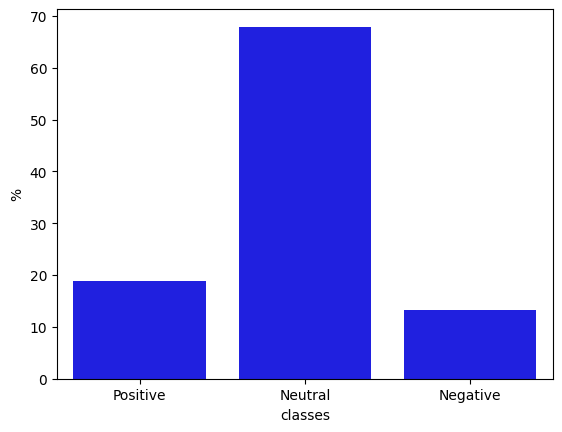

	Positive in %:  Positive    18.877514
Name: VADER_class, dtype: float64 
	Negative in %:  Negative    13.225609
Name: VADER_class, dtype: float64 
	Neutral in %:  Neutral    67.896877
Name: VADER_class, dtype: float64


,body,timestamp,cleaned_text,neg,neu,pos,compound,VADER_class
6484963,Cream pie a pussy,2022-12-30,Cream pie pussy,0.0,1.0,0.0,0.0000,Neutral
201303,You know he ended up on his knees and liked it🍆,2022-12-30,You know ended knees liked it🍆,0.0,0.797,0.203,0.4215,Neutral
201312,Well tbh by the way you’ve worded this it seem...,2022-12-30,Well tbh way you’ve worded seems wife know inv...,0.114,0.82,0.066,-0.6808,Negative
201311,"Oh my gourd! \r\n\r\n\r\n*I am a bot, and this...",2022-12-30,"Oh gourd! *I bot, action performed automatical...",0.0,0.909,0.091,0.3802,Neutral
201310,A tale as old as time.,2022-12-30,A tale old time.,0.0,1.0,0.0,0.0000,Neutral


In [ ]:
#sentiment analysis finito
redditdf['VADER_class'] = redditdf['compound'].apply(lambda x: "Positive" if x > 0.5 else "Negative" if x < -0.5 else "Neutral")
#print(redditdf['VADER_class'])

N = len(redditdf)

all = redditdf['VADER_class'].value_counts()
pos = redditdf["VADER_class"][redditdf["VADER_class"] == "Positive"].value_counts()
neg = redditdf["VADER_class"][redditdf["VADER_class"] == "Negative"].value_counts()
neu = redditdf["VADER_class"][redditdf["VADER_class"] == "Neutral"].value_counts()


all1 = pd.DataFrame({"class": ["Positive", "Neutral", "Negative"],
                     "num": [(int(pos)/N)*100, (int(neu)/N)*100, (int(neg)/N)*100]})

#absolute val
sns.barplot(x = "class", y = "num", color = "blue", data = all1)
plt.ylabel("%")
plt.xlabel("classes")
plt.show()

print("\tPositive in %: ", (pos/N)*100, "\n\tNegative in %: ", (neg/N)*100, "\n\tNeutral in %: ", (neu/N)*100)

redditdf.head()

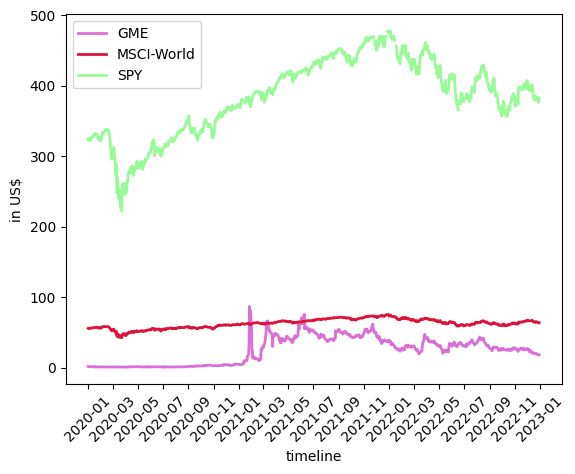

In [ ]:
#indices over time
sym1 = findf["GME"]
sym2 = findf["MSCI_WORLD"]
sym3 = findf["SPY"]

#timeline
x_axis1 = findf["Date"] 

#plot -> indices
fig, ax = plt.subplots()
ax.plot(x_axis1, sym1, label = "GME", color = "orchid", linewidth = 2)
ax.plot(x_axis1, sym2, label = "MSCI-World", color = "crimson", linewidth = 2)
ax.plot(x_axis1, sym3, label = "SPY", color = "palegreen", linewidth = 2)
plt.ylabel("in US$")
plt.xlabel("timeline")

#stepsize of date = 2months
loc = MonthLocator(interval=2)
ax.xaxis.set_major_locator(loc)

plt.setp(ax.get_xticklabels(), rotation=45)
plt.legend()
plt.show()

In [ ]:
#grouping values
daily_class = redditdf.groupby(["timestamp", "VADER_class"]).size().unstack(fill_value=0)
daily_class = daily_class.astype(int)
daily_class.reset_index(inplace = True)
pos = (daily_class["Positive"])/N*100
neu = (daily_class["Neutral"])/N*100
neg = (daily_class["Negative"])/N*100

In [ ]:
#merging the csv-files
merge_df = pd.merge(redditdf, findf, left_on = "timestamp", right_on = "Date")

#merge_df.head(-10)

In [ ]:
merge_df.dtypes

body             object
timestamp        object
cleaned_text     object
neg              object
neu              object
pos              object
compound        float64
VADER_class      object
Date             object
GME             float64
MSCI_WORLD      float64
SPY             float64
dtype: object

In [ ]:
#creating column "days" to calculate with --> Day0 = 2020-12-08; Day752 = 2022-12-30 
merge_df["delta"] = pd.to_numeric((merge_df["timestamp"] - min(merge_df["timestamp"])).dt.days, downcast = "integer")
merge_df["pos"] = pd.to_numeric(merge_df["pos"]).astype(float)
merge_df["neu"] = pd.to_numeric(merge_df["neu"]).astype(float)
merge_df["neg"] = pd.to_numeric(merge_df["neg"]).astype(float)
merge_df = merge_df.dropna()

merge_df.dtypes

body             object
timestamp        object
cleaned_text     object
neg             float64
neu             float64
pos             float64
compound        float64
VADER_class      object
Date             object
GME             float64
MSCI_WORLD      float64
SPY             float64
delta             int16
dtype: object

In [ ]:
#now the regression operators:
#features = list(merge_df.columns["delta", "neg", "neu", "pos", "compound"])
df = pd.DataFrame().assign(Delta = merge_df["delta"], Compound = merge_df["compound"]).dropna()
features = list(df.dropna())
df.dtypes

Delta         int16
Compound    float64
dtype: object

In [ ]:
merge_df.corr()

C:\Users\Antonia\AppData\Local\Temp\ipykernel_24792\920794679.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merge_df.corr()


,neg,neu,pos,compound,GME,MSCI_WORLD,SPY,delta
neg,1.000000,-0.600767,-0.166557,-0.638526,-0.007632,0.002155,0.003523,0.007379
neu,-0.600767,1.000000,-0.688195,-0.051025,0.014722,-0.000242,-0.000819,0.001249
pos,-0.166557,-0.688195,1.000000,0.642437,-0.011235,-0.001660,-0.002189,-0.008239
compound,-0.638526,-0.051025,0.642437,1.000000,0.000451,0.000753,-0.002236,-0.011808
GME,-0.007632,0.014722,-0.011235,0.000451,1.000000,-0.044731,-0.064472,0.057395
MSCI_WORLD,0.002155,-0.000242,-0.001660,0.000753,-0.044731,1.000000,0.906731,0.460958
SPY,0.003523,-0.000819,-0.002189,-0.002236,-0.064472,0.906731,1.000000,0.558560
delta,0.007379,0.001249,-0.008239,-0.011808,0.057395,0.460958,0.558560,1.000000


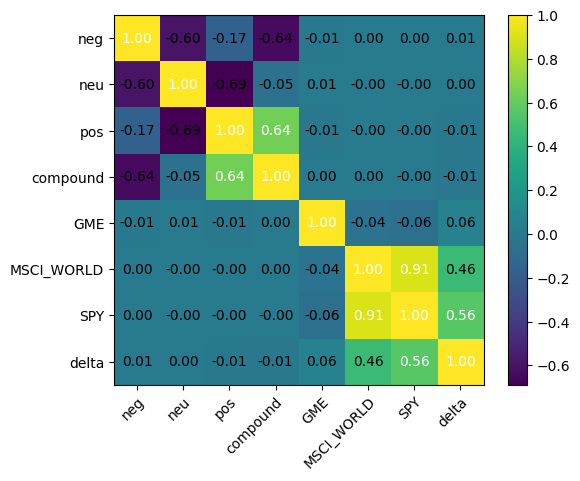

In [ ]:
columns = ["neg", "neu", "pos", "compound", "GME", "MSCI_WORLD", "SPY", "delta"]
cm = np.corrcoef(merge_df[columns].values.T)
hm = heatmap (cm, row_names=columns, column_names=columns)
plt.show()

In [ ]:
features = list(df)
#print(features) --> just print it, if your PC can handle that. Otherwise: don't do it.

target1 = "GME"
target2 = "MSCI_WORLD"
target3 = "SPY"
#target1.reset_index(inplace = True)
#target2.reset_index(inplace = True)
#target3.reset_index(inplace = True)

In [ ]:
#normalizing data
def get_data(df, features, normalize = False):
    X = df.loc[:, features]
    if not normalize:
        return X.to_numpy()
    return preprocessing.scale(X)

In [ ]:
X_norm = get_data(df, features, normalize = True)
X = get_data(df, features)

y1_norm = get_data(merge_df, target1, normalize = True)
y1 = get_data(merge_df, target1)

y2_norm = get_data(merge_df, target2, normalize = True)
y2 = get_data(merge_df, target2)

y3_norm = get_data(merge_df, target3, normalize = True)
y3 = get_data(merge_df, target3)

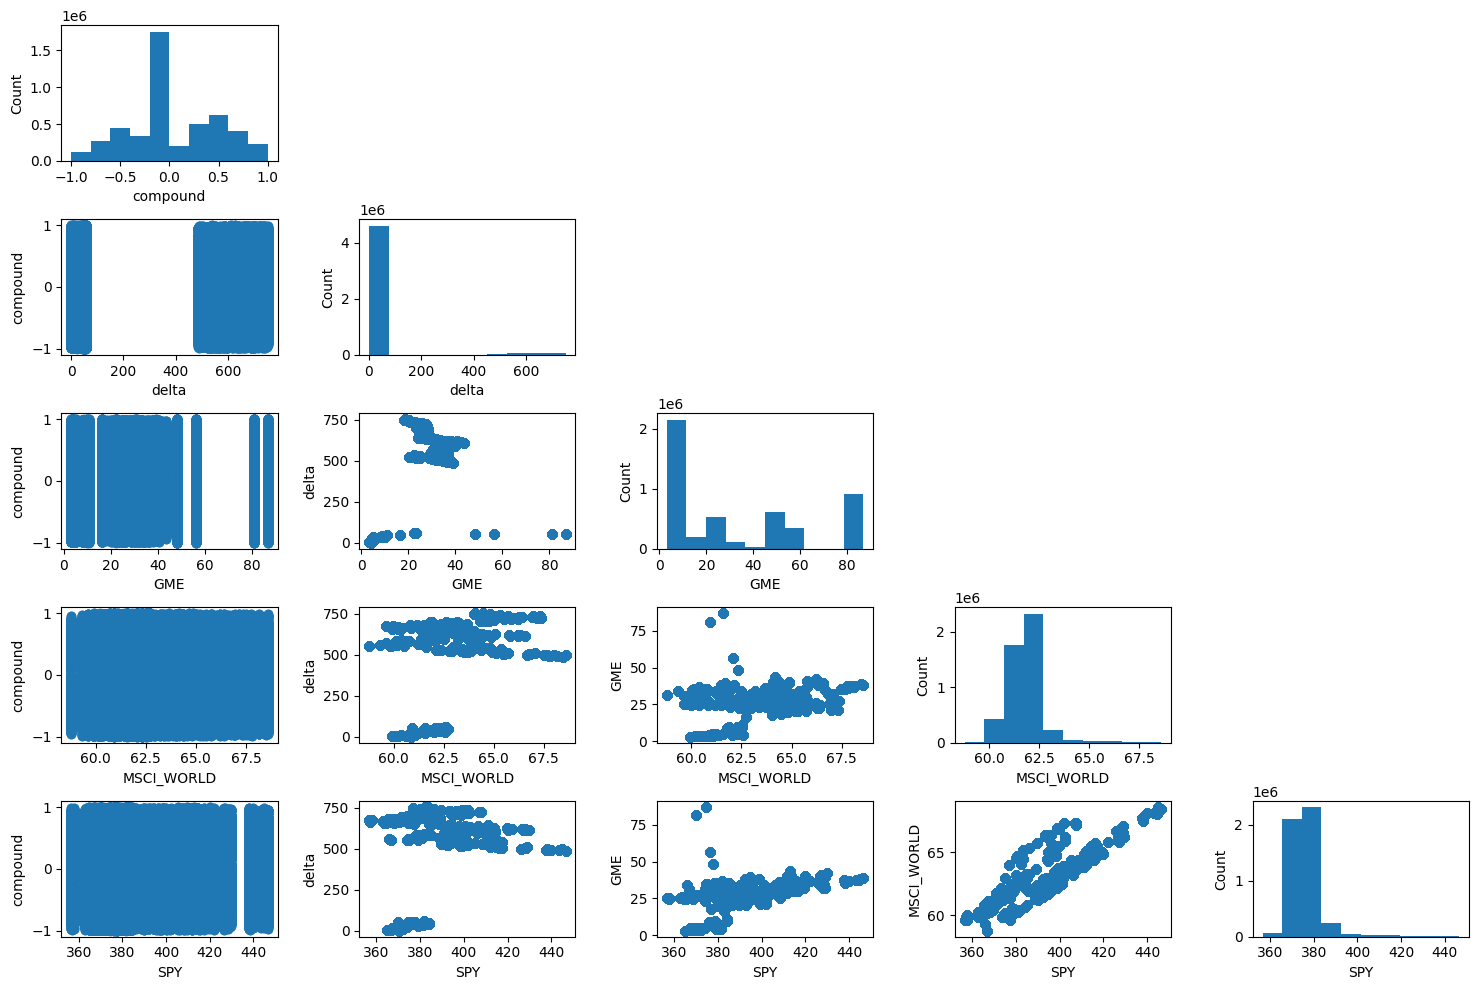

In [ ]:
#scatterplots
columns = ["compound", "delta", "GME", "MSCI_WORLD", "SPY"]

scatterplotmatrix(merge_df[columns].values, figsize = (15,10), names = columns)
plt.tight_layout()
plt.show()

In [ ]:
#MSE (mean squared error), bias, variance using k-fold (k=5) for GME
lam = 1.0
reg = Ridge(alpha = 1.0)
cv = KFold(n_splits=5)

def cross_validate(X, y1, lam=1.0):
    mse1 = []
    bias1 = []
    variance1 = []
    #splitting the data to 5 parts -> 1 test dataset + 4 training datasets. Therefore I can check how consistent it is.
    

    #performing cross validation + getting y-mean + beta-mean
    reg = Ridge(alpha=lam)
    for train, test in cv.split(X):
        X_train, X_test, y1_train, y1_test = X[train], X[test], y1[train], y1[test]
        
        m = reg.fit(X_train, y1_train)
        y1_hat = reg.predict(X_test)
        beta = reg.coef_
        mse1.append(mean_squared_error(y1_test, y1_hat))
        bias1.append(np.mean(y1_hat - y1_test)**2)
        variance1.append(np.var(y1_hat))
    print(np.mean(y1_hat), "\n", np.mean(beta))
    
    return(np.mean(mse1), np.mean(bias1), np.mean(variance1))

#k-fold cross validation with lambda = 1.0
mse1, bias1, variance1 = cross_validate(X_norm, y1_norm, 1)

print

print("GME\nfor lambda = 1.0: \n\tmse=%f \n\tbias=%f \n\tvariance=%f"%(mse1,bias1,variance1))

0.26566952362526136 
 -0.028826618330068
GME
for lambda = 1.0: 
	mse=45.414299 
	bias=14.777585 
	variance=29.701481


In [ ]:
#cv + reg
reg.fit

<bound method Ridge.fit of Ridge()>

In [ ]:
#MSE (mean squared error), bias, variance using k-fold (k=5) for MSCI-World

def cross_validate(X, y2, lam=1.0):
    mse2 = []
    bias2 = []
    var2 = []
    #splitting the data to 5 parts -> 1 test dataset + 4 training datasets. Therefore I can check how consistent it is.

    #performing cross validation + getting y-mean + beta-mean
    reg = Ridge(alpha=lam)
    for train, test in cv.split(X):
        X_train, X_test, y2_train, y2_test = X[train], X[test], y2[train], y2[test]
        
        reg.fit(X_train, y2_train)
        y2_hat = reg.predict(X_test)
        beta = reg.coef_

        mse2.append(mean_squared_error(y2_test, y2_hat))
        bias2.append(np.mean(y2_hat - y2_test)**2)
        var2.append(np.var(y2_hat))
        
        
    print(np.mean(y2_hat), "\n", np.mean(beta))
    return(np.mean(mse2), np.mean(bias2), np.mean(var2))

#k-fold cross validation with lambda = 1.0
mse2, bias2, variance2 = cross_validate(X_norm, y2_norm, 1.0)

print("MSCI_WORLD\nfor lambda = 1.0: \n\tmse=%f \n\tbias=%f \n\tvariance=%f"%(mse2,bias2,variance2,))

0.04441307113599987 
 0.1827356449733788
MSCI_WORLD
for lambda = 1.0: 
	mse=9.207266 
	bias=2.303914 
	variance=7.568198


In [ ]:
#MSE (mean squared error), bias, variance using k-fold (k=5) for SPY

def cross_validate(X, y3, lam=1.0):
    mse3 = []
    bias3 = []
    var3 = []
    #splitting the data to 5 parts -> 1 test dataset + 4 training datasets. Therefore I can check how consistent it is.

    #performing cross validation + getting y-mean + beta-mean
    reg = Ridge(alpha=lam)
    for train, test in cv.split(X):
        X_train, X_test, y3_train, y3_test = X[train], X[test], y3[train], y3[test]

        reg.fit(X_train, y3_train)
        y3_hat = reg.predict(X_test)
        beta = reg.coef_

        mse3.append(mean_squared_error(y3_test, y3_hat))
        bias3.append(np.mean(y3_hat - y3_test)**2)
        var3.append(np.var(y3_hat))
    print(np.mean(y3_hat), "\n", np.mean(beta))
    return(np.mean(mse3), np.mean(bias3), np.mean(var3))

#k-fold cross validation with lambda = 1.0
mse3, bias3, variance3 = cross_validate(X_norm, y3_norm, 1.0)

print("SPY: \nfor lambda = 1.0: \n\tmse=%f \n\tbias=%f \n\tvariance=%f"%(mse3,bias3,variance3,))

-0.045136475854609184 
 0.2401987440228703
SPY: 
for lambda = 1.0: 
	mse=4.883074 
	bias=1.182787 
	variance=4.553309
